# Denoising Pipeline Development

In [ ]:
%load_ext autoreload
%autoreload 2

import fibsem
import salami
from fibsem import utils, acquire, alignment, calibration, milling
from fibsem.structures import BeamType, FibsemPatternSettings, FibsemMillingSettings, FibsemPattern
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import logging

from salami.structures import SalamiSettings, run_salami, create_sweep_parameters



In [ ]:
microscope, settings = utils.setup_session()


In [ ]:
eb_image, ib_image = acquire.take_reference_images(microscope, settings.image)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(eb_image.data, cmap="gray")
ax[1].imshow(ib_image.data, cmap="gray")
plt.show()


### Move Raw Images to a New Directory

In [ ]:
%load_ext autoreload
%autoreload 2

import glob
import os
from pathlib import Path


path = "/home/patrick/github/salami/salami/denoise/raw_imgs"
slow_filenames = sorted(glob.glob(os.path.join(path, "*5e-06*.tif")))
fast_filenames = sorted(glob.glob(os.path.join(path, "*5e-07*.tif")))


from pprint import pprint
raw_path = "/home/patrick/github/salami/data/20230310/raw"


os.makedirs(os.path.join(raw_path, "slow"), exist_ok=True)
os.makedirs(os.path.join(raw_path, "fast"), exist_ok=True)

for fname in fast_filenames:

    idx = int(os.path.splitext(os.path.basename(fname))[0].split("_")[1])
    print(os.path.join(raw_path, "fast",  f"{idx:06d}.tif"))

    # copy file with os
    # os.system(f"cp {fname} {os.path.join(raw_path, 'fast',  f'{idx:06d}.tif')}")




In [ ]:

raw_path = "/home/patrick/github/salami/data/20230310/raw"

fast_filenames = sorted(glob.glob(os.path.join(raw_path, "fast", "*.tif")))
slow_filenames = sorted(glob.glob(os.path.join(raw_path, "slow", "*.tif")))


from pprint import pprint

# pprint(fast_filenames)

import math

from salami.denoise.inference import get_window, get_index, get_closest_index

window_size = 5
for idx, fname in enumerate(fast_filenames):

    # idx = get_index(fname) # this is based on the fname which means nothing
    window = get_window(fast_filenames, idx, window_size=window_size)
    if len(window) < window_size:
        continue
    # closest = get_closest_index(window, idx)
    # print(f"index: {idx}, closest: {get_index(closest)}")
    print(f"index: {idx}, window: {[get_index(f) for f in window]}")
    # print(window)
    

## Segmentation Diagnostics

In [ ]:
%load_ext autoreload
%autoreload 2

import os
from salami.segmentation import segmentation as sseg

path = "/home/patrick/github/salami/salami/output/seg"

stats = sseg.calc_seg_diagnostic(path, plot=True)

In [ ]:
print(stats["counts"].shape)

In [ ]:
df = sseg.calculate_diag_df(stats)
display(df)

In [ ]:
# plot the counts

# get column names except fname

labels = df.columns[:-1]
df.plot(x="fname", y=labels, kind="line", figsize=(10,5)) 
# df.plot(x="fname", y=stats["labels"], kind="line", figsize=(10,5))

## WatchDog Testing

In [ ]:
%load_ext autoreload
%autoreload 2

import glob
import os
from pathlib import Path


path = "/home/patrick/github/salami/salami/denoise/raw_imgs"
# slow_filenames = sorted(glob.glob(os.path.join(path, "*5e-06*.tif")))
fast_filenames = sorted(glob.glob(os.path.join(path, "*5e-07*.tif")))


from pprint import pprint
raw_path = "/home/patrick/github/salami/salami/output2/raw"

# os.makedirs(os.path.join(raw_path, "slow"), exist_ok=True)
os.makedirs(raw_path, exist_ok=True)
import time
for fname in fast_filenames:

    idx = int(os.path.splitext(os.path.basename(fname))[0].split("_")[1])
    print(os.path.join(raw_path, f"{idx:06d}.tif"))

    # copy file with os
    os.system(f"cp {fname} {os.path.join(raw_path, f'{idx:06d}.tif')}")

    time.sleep(0.5)


In [ ]:
# simulate latency of 45sec vs 12 sec
# plot a graph of 1 image per 12 sec vs 1 image per 45 sec

# 1 per 12
# 1 per 45

fps12 = 1 / 12 # frames per seconds
fps45 = 1 / 45 # frames per seconds 

print(fps12, fps45)

import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0, 1000, 1)
y1 = fps12 * x
y2 = fps45 * x

plt.plot(x, y1, label="12 spf")
plt.plot(x, y2, label="45 spf")
# difference
plt.plot(x, y1 - y2, label="difference")
plt.xlabel("number of seconds")
plt.ylabel("number of images")
plt.legend()
plt.show()

In [ ]:
from salami.denoise.frame import *
import matplotlib.pyplot as plt

# how to calculate FRC between to images & calculate PSNR

# load image, split in half save files
from fibsem.structures import FibsemImage
import tifffile as tff

import glob
path = "/home/patrick/github/data/salami/analysis/2023-04-14-07-05-07PM/data"
filenames = sorted(glob.glob(os.path.join(path, "*.tif")))

for fname in filenames:


    img = FibsemImage.load(fname)

    # split in half
    img1 = img.data[:, :img.data.shape[1]//2]
    img2 = img.data[:, img.data.shape[1]//2:]

    # save
    tmp_dir = os.path.join(os.path.dirname(fname), "tmp")
    os.makedirs(tmp_dir, exist_ok=True)

    fname1 = os.path.join(tmp_dir, "tmp1.tif")
    fname2 = os.path.join(tmp_dir, "tmp2.tif")
    tff.imwrite(fname1, img1)
    tff.imwrite(fname2, img2)


    # read
    img1 = Frame(filename=fname1)
    img2 = Frame(filename=fname2)

    # remove borders
    border = 128
    img1 = img1.clip(border, border, border, border)
    img2 = img2.clip(border, border, border, border)

    # PSNR
    psnr = img1.calcPSNR(img2)

    # FRC
    # image normalization, masking, Fourier transformation
    img1.normalize()
    img1.taperEdges(0.95)  # rectangular Tukey windowing (= cosine edge)
    img1.fft()

    img2.normalize()
    img2.taperEdges(0.95)  # rectangular Tukey windowing (= cosine edge)
    img2.fft()

    # actual calculation & plot
    g, frc = img1.calcFRC(img2)


    # subplot image and metric
    import matplotlib.pyplot as plt
    print(f"{os.path.basename(fname)}, {img.data.shape}, PSNR: {psnr:.2f}")

    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(img.data, cmap="gray")
    ax[1].plot(g, frc)
    plt.show()

# TODO: port this to not use the Frame class
# TODO: getting negative values?
# TODO: need to understand what is happening


## Analysis Pipeline

In [1]:
%load_ext autoreload
%autoreload 2

from salami import analysis as sa
from fibsem.structures import FibsemImage

import os
import glob

from scipy import ndimage
import matplotlib.pyplot as plt

import pandas as pd
import os
import glob
from tqdm import tqdm
import numpy as np



Calculating FRC: 000000_eb.tif, split: checkerboard:   0%|          | 0/90 [00:00<?, ?it/s]

1024 1536
[3072.         1536.         1024.          768.          614.4
  512.          438.85714286  384.          341.33333333  307.2
  279.27272727  256.          236.30769231  219.42857143  204.8
  192.          180.70588235  170.66666667  161.68421053  153.6
  146.28571429  139.63636364  133.56521739  128.          122.88
  118.15384615  113.77777778  109.71428571  105.93103448  102.4
   99.09677419   96.           93.09090909   90.35294118   87.77142857
   85.33333333   83.02702703   80.84210526   78.76923077   76.8
   74.92682927   73.14285714   71.44186047   69.81818182   68.26666667
   66.7826087    65.36170213   64.           62.69387755   61.44
   60.23529412   59.07692308   57.96226415   56.88888889   55.85454545
   54.85714286   53.89473684   52.96551724   52.06779661   51.2
   50.36065574   49.5483871    48.76190476   48.           47.26153846
   46.54545455   45.85074627   45.17647059   44.52173913   43.88571429
   43.26760563   42.66666667   42.08219178   41.51351351 

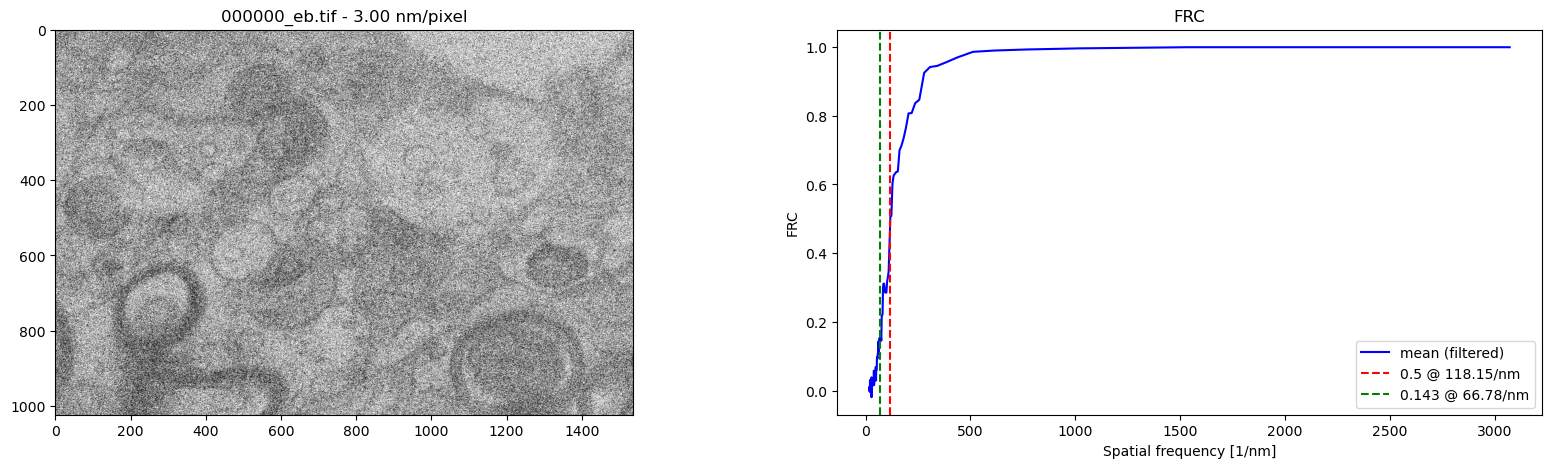

Calculating FRC: 000001_eb.tif, split: checkerboard:   1%|          | 1/90 [00:08<12:23,  8.36s/it]

1024 1536
[3072.         1536.         1024.          768.          614.4
  512.          438.85714286  384.          341.33333333  307.2
  279.27272727  256.          236.30769231  219.42857143  204.8
  192.          180.70588235  170.66666667  161.68421053  153.6
  146.28571429  139.63636364  133.56521739  128.          122.88
  118.15384615  113.77777778  109.71428571  105.93103448  102.4
   99.09677419   96.           93.09090909   90.35294118   87.77142857
   85.33333333   83.02702703   80.84210526   78.76923077   76.8
   74.92682927   73.14285714   71.44186047   69.81818182   68.26666667
   66.7826087    65.36170213   64.           62.69387755   61.44
   60.23529412   59.07692308   57.96226415   56.88888889   55.85454545
   54.85714286   53.89473684   52.96551724   52.06779661   51.2
   50.36065574   49.5483871    48.76190476   48.           47.26153846
   46.54545455   45.85074627   45.17647059   44.52173913   43.88571429
   43.26760563   42.66666667   42.08219178   41.51351351 

Calculating FRC: 000001_eb.tif, split: checkerboard:   1%|          | 1/90 [00:16<24:13, 16.34s/it]


KeyboardInterrupt: 

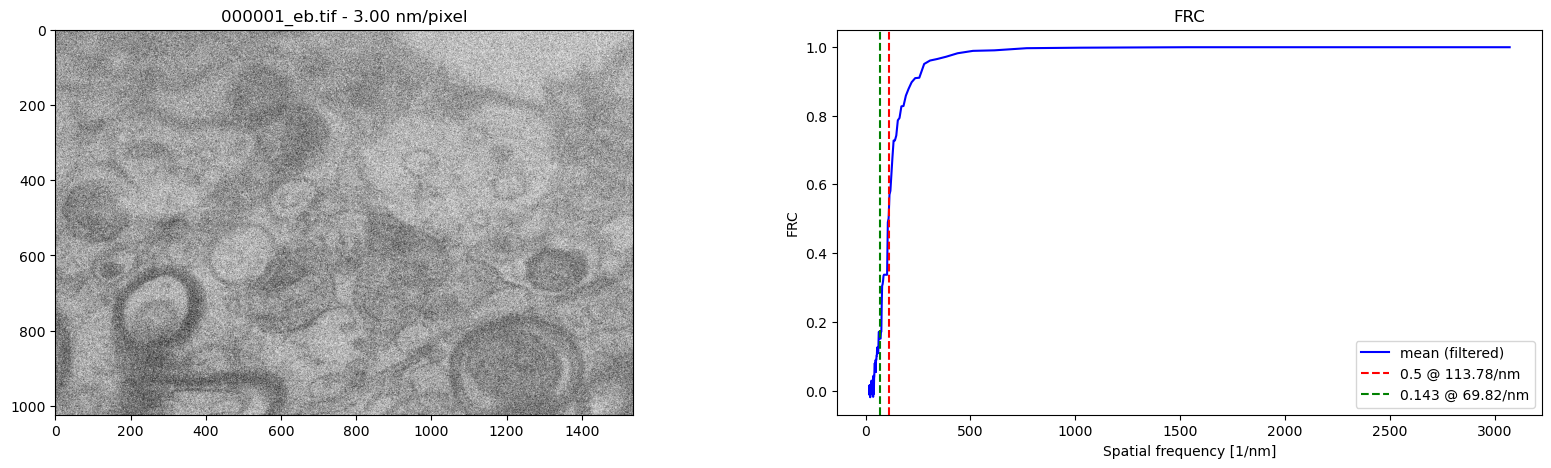

In [10]:

# x axis = 1 / nm


path = "/home/patrick/github/data/salami/analysis/2023-04-14-07-05-07PM/data"
df = sa.run_salami_analysis_frc(path, plot=True, show=True)



In [29]:
df = pd.read_csv(os.path.join(path, "metrics.csv"))

# parameters + metrics
df = sa.join_df(path)
display(df)


,voltage,current,resolution_x,resolution_y,hfw,pixelsize,dwell_time,idx,path,basename,metric,int_05,int_0143
0,2000.0,2.000000e-10,1536,1024,0.000005,3.0,5.000000e-07,0,D:\projects\salami/analysis\2023-04-14-07-05-0...,000000_eb.tif,[ 1.00000000e+00 9.98557401e-01 9.95273333e-...,8.333333,15.000000
1,2000.0,2.000000e-10,1536,1024,0.000005,3.0,1.000000e-06,1,D:\projects\salami/analysis\2023-04-14-07-05-0...,000001_eb.tif,[ 1.00000000e+00 9.98589146e-01 9.95769158e-...,8.666667,14.333333
2,2000.0,2.000000e-10,1536,1024,0.000005,3.0,3.000000e-06,2,D:\projects\salami/analysis\2023-04-14-07-05-0...,000002_eb.tif,[ 1.00000000e+00 9.99785877e-01 9.98466674e-...,15.666667,25.666667
3,2000.0,2.000000e-10,1536,1024,0.000005,3.0,5.000000e-06,3,D:\projects\salami/analysis\2023-04-14-07-05-0...,000003_eb.tif,[ 1.00000000e+00 9.99753717e-01 9.99490994e-...,18.333333,28.666667
4,2000.0,2.000000e-10,1536,1024,0.000005,3.0,8.000000e-06,4,D:\projects\salami/analysis\2023-04-14-07-05-0...,000004_eb.tif,[ 1.00000000e+00 9.99873161e-01 9.99753701e-...,18.666667,33.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2000.0,8.000000e-10,1536,1024,0.000015,10.0,5.000000e-07,85,D:\projects\salami/analysis\2023-04-14-07-05-0...,000085_eb.tif,[ 1.00000000e+00 9.99537323e-01 9.97893234e-...,4.700000,9.000000
86,2000.0,8.000000e-10,1536,1024,0.000015,10.0,1.000000e-06,86,D:\projects\salami/analysis\2023-04-14-07-05-0...,000086_eb.tif,[1. 0.99935538 0.99878581 0.99747334 0...,6.000000,9.500000
87,2000.0,8.000000e-10,1536,1024,0.000015,10.0,3.000000e-06,87,D:\projects\salami/analysis\2023-04-14-07-05-0...,000087_eb.tif,[1. 0.99991158 0.99942669 0.99932572 0...,8.600000,15.900000
88,2000.0,8.000000e-10,1536,1024,0.000015,10.0,5.000000e-06,88,D:\projects\salami/analysis\2023-04-14-07-05-0...,000088_eb.tif,[1. 0.99996604 0.99977792 0.99964081 0...,10.600000,17.300000


In [30]:
import plotly.express as px


# convert dwell time to category
df["dwell_time"] = df["dwell_time"].astype("category")

# plot 3d scatter plot with current, pixelsize and int_05 color by dwell time
fig = px.scatter_3d(df, x="current", 
                    y="pixelsize", 
                    z="int_05", 
                    color="dwell_time", 
                    opacity=0.5)
fig.show()


# plot 3d scatter plot with current, pixelsize and int_0143 color by dwell time
fig = px.scatter_3d(df, x="current", 
                    y="pixelsize", 
                    z="int_0143", 
                    color="dwell_time", 
                    opacity=0.5)
fig.show()

In [31]:

# plot line plot with pixelsize and int_05 color by dwell time, marker by current

fig = px.line(df, x="pixelsize", y="int_05", 
              color="dwell_time", 
              line_group="current",
              line_dash="current", 
              hover_name="basename")

# set title
fig.update_layout(title="FRC 0.5")

fig.show()

fig = px.line(df, x="pixelsize", y="int_0143", 
              color="dwell_time", 
              line_group="current",
              line_dash="current", 
              hover_name="basename")
# set title
fig.update_layout(title="FRC 0.143")
fig.show()


In [ ]:


# group by current
df_group = df.groupby("current").mean().reset_index()


## Experiment Management


In [24]:
%load_ext autoreload
%autoreload 2

from salami.structures import Experiment, SalamiSettings, SalamiImageSettings

from fibsem.structures import ImageSettings, BeamType, BeamSettings, FibsemDetectorSettings, MicroscopeState
from fibsem import utils as futils
from fibsem.patterning import FibsemMillingStage

import os



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
microscope, settings = futils.setup_session(manufacturer="Demo")


2023-05-17 13:08:13,130 — root — INFO — connect_to_microscope:3758 — Connected to Demo Microscope
2023-05-17 13:08:13,132 — root — INFO — setup_session:229 — Finished setup for session: demo_2023-05-17-01-08-13PM


In [26]:


PATH = os.getcwd()
exp = Experiment(path=PATH, name="salami")

print(exp)

Experiment: 
        Path: c:\Users\pcle0002\Documents\repos\salami\salami\salami
        Settings: None
        Positions: 0
        


In [27]:
beam_type=  BeamType.ELECTRON
exp.settings = SalamiSettings(
    n_steps=10,
    step_size=150e-9,
    image = [SalamiImageSettings(
        ImageSettings(beam_type=beam_type), 
        BeamSettings(beam_type=beam_type), 
        FibsemDetectorSettings()
        )
    ],
    mill = FibsemMillingStage()
)


In [28]:
from pprint import pprint
pprint(exp.settings)

SalamiSettings(n_steps=10, step_size=1.5e-07, image=[SalamiImageSettings(image=ImageSettings(resolution=None, dwell_time=None, hfw=None, autocontrast=None, beam_type=<BeamType.ELECTRON: 1>, save=None, label=None, gamma_enabled=None, save_path=None, reduced_area=None), beam=BeamSettings(beam_type=<BeamType.ELECTRON: 1>, working_distance=None, beam_current=None, voltage=None, hfw=None, resolution=None, dwell_time=None, stigmation=None, shift=None), detector=FibsemDetectorSettings(type=None, mode=None, brightness=None, contrast=None))], mill=FibsemMillingStage(name='Milling Stage', num=0, milling=FibsemMillingSettings(milling_current=2e-11, spot_size=5e-08, rate=0.003, dwell_time=1e-06, hfw=0.00015, patterning_mode='Serial', application_file='Si', preset='30 keV; UHR imaging'), pattern=RectanglePattern(name='Rectangle', required_keys=('width', 'height', 'depth', 'rotation'))), _align=True, _milling=True, _neutralise=True)


In [29]:
exp.save()
print(exp)

Experiment: 
        Path: c:\Users\pcle0002\Documents\repos\salami\salami\salami
        Settings: SalamiSettings(n_steps=10, step_size=1.5e-07, image=[SalamiImageSettings(image=ImageSettings(resolution=None, dwell_time=None, hfw=None, autocontrast=None, beam_type=<BeamType.ELECTRON: 1>, save=None, label=None, gamma_enabled=None, save_path=None, reduced_area=None), beam=BeamSettings(beam_type=<BeamType.ELECTRON: 1>, working_distance=None, beam_current=None, voltage=None, hfw=None, resolution=None, dwell_time=None, stigmation=None, shift=None), detector=FibsemDetectorSettings(type=None, mode=None, brightness=None, contrast=None))], mill=FibsemMillingStage(name='Milling Stage', num=0, milling=FibsemMillingSettings(milling_current=2e-11, spot_size=5e-08, rate=0.003, dwell_time=1e-06, hfw=0.00015, patterning_mode='Serial', application_file='Si', preset='30 keV; UHR imaging'), pattern=RectanglePattern(name='Rectangle', required_keys=('width', 'height', 'depth', 'rotation'))), _align=True, 

In [32]:
LOAD_PATH = r"C:\Users\pcle0002\Documents\repos\salami\salami\salami\salami.yaml"
exp2 = Experiment.load(LOAD_PATH)
print(exp2)

Experiment: 
        Path: c:\Users\pcle0002\Documents\repos\salami\salami\salami
        Settings: 1 Images
        Positions: 0 Positions
        
